<a href="https://colab.research.google.com/github/mnwato/captcha-recognition/blob/master/sheypoor/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Lib

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d fournierp/captcha-version-2-images

!unzip /content/captcha-version-2-images.zip
!rm /content/captcha-version-2-images.zip

In [2]:
from matplotlib import pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import time
import heapq
import os
import cv2

In [3]:
# The PlotLosses function, plots the validation and training loss function during the
#  training to give an insight of training the model
import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        # self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.grid()
        # plt.show();
        plt.subplot(1,2,2)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.grid()
        plt.show();
        
        print('Validation metrics:')
        print('val_losses: {}'.format(round(self.val_losses[-1], 3)),
        'val_accuracy: {}'.format(round(self.val_accuracy[-1], 3)) )
        
plot_losses = PlotLosses()

In [4]:
use_colab = True

# labels
!gdown --i 1V_mFYCQk2tbvi9Nc6WXQrllQWJV0gOzg
# labels2
!gdown --i 102_85qewhU45Xwz262SzjsJ82OKIRpPT
# digits
!gdown --i 141HrMeZvari7mCBmqyneAL4QI1qwz2qI
# # chaptcha images 999
# !gdown --i 1egp2ncrof0wuG-BQbVwSAWK64bB4zl1b
# chaptcha images 2999
!gdown --i 1WrZmKh6k7d9XDOZoziomeZlozQUD-Myh

!unzip /content/dataset.zip
!rm /content/dataset.zip

!unzip /content/digits-dataset.zip
!rm /content/digits-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/captcha1079.jpg  
  inflating: dataset/captcha108.jpg  
  inflating: dataset/captcha1080.jpg  
  inflating: dataset/captcha1081.jpg  
  inflating: dataset/captcha1082.jpg  
  inflating: dataset/captcha1083.jpg  
  inflating: dataset/captcha1084.jpg  
  inflating: dataset/captcha1085.jpg  
  inflating: dataset/captcha1086.jpg  
  inflating: dataset/captcha1087.jpg  
  inflating: dataset/captcha1088.jpg  
  inflating: dataset/captcha1089.jpg  
  inflating: dataset/captcha109.jpg  
  inflating: dataset/captcha1090.jpg  
  inflating: dataset/captcha1091.jpg  
  inflating: dataset/captcha1092.jpg  
  inflating: dataset/captcha1093.jpg  
  inflating: dataset/captcha1094.jpg  
  inflating: dataset/captcha1095.jpg  
  inflating: dataset/captcha1096.jpg  
  inflating: dataset/captcha1097.jpg  
  inflating: dataset/captcha1098.jpg  
  inflating: dataset/captcha1099.jpg  
  inflating: dataset/captcha11.jpg   
  inflating: dat

# Getting golestan captcha

In [ ]:
import requests
import base64
import numpy as np
import time

url = 'https://edu.znu.ac.ir/Forms/AuthenticateUser/captcha.aspx?0.40381493127445034&x859=386&x763=844'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36"}


for i in range(944,1000):
    x = requests.get(url, headers=headers, stream=True)

    a = x.content

    with open(f'./dataset-golestan/captcha{i}.jpg','wb') as f:
        f.write(a)
    delay = np.random.randint(2)
    time.sleep(10)

FileNotFoundError: [Errno 2] No such file or directory: './dataset-golestan/captcha944.jpg'

# Getting captcha from sheypoor website

In [ ]:
import requests
import base64
import numpy as np
import time

url = 'https://www.sheypoor.com/api/web/captcha/refresh'
headers = {
    "authority": "www.sheypoor.com",
    "method": "POST",
    "path": "/api/web/captcha/refresh",
    "scheme": "https",
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "en-US,en;q=0.9",
    "content-length": "38",
    "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
    "cookie": "plog=False; ts=b536dc923761e246fa3d552db50df071; track_id=e2e687919ce5e3f3a9a85f682145651c; AMP_TOKEN=%24NOT_FOUND; _ga=GA1.2.527994953.1644523644; _gid=GA1.2.672309292.1644523644; _gat=1",
    "origin": "https://www.sheypoor.com",
    # "referer": "https://www.sheypoor.com/%D9%81%D8%B1%D8%B2-%D8%A8%D8%B2%D8%B1%DA%AF-%D8%A7%D9%87%D9%86%DA%AF%D8%B1%DB%8C-%D8%B3%D9%86%DA%AF%D8%A8%D8%B1%DB%8C-%D8%AF%DB%8C%D9%85%D8%B1-%D8%AF%D8%A7%D8%B1-%D8%A8%D8%A7%D8%B3-402738844.html",
    "sec-ch-ua": '"Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": "Windows",
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors", 
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36",
    "x-requested-with": "XMLHttpRequest"
}
data = {"token": "103159f5a73c63cacc4c9d8680d45325"}

for i in range(500,1000):
    x = requests.post(url, headers=headers, data=data, stream=True)

    a = x.json()['data']['image']
    a = a.encode('utf-8')

    with open(f'./dataset/captcha{i}.jpg','wb') as f:
        f.write(base64.decodebytes(a))
    delay = np.random.randint(5)
    # time.sleep(delay)

# preprocessing images

In [ ]:
# LOADING IMAGES

import cv2
import os
# import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def load_images():
    root_path = os.getcwd()
    dataset_path = os.path.join(root_path, 'dataset')
    # dataset_path = os.path.join(root_path, 'dataset-golestan')
    images = [img for img in os.listdir(dataset_path)]
    return images, dataset_path

captcha13.jpg


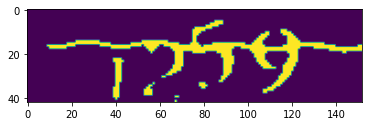

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# 501
# PREPROCESS LOADED IMAGES
def preprocessing(image, dataset_path):
    print(image)
    org_image = cv2.imread(os.path.join(dataset_path, image))
    image_gray = cv2.cvtColor(org_image, cv2.COLOR_RGB2GRAY)
    # crop_image = image_gray[:int(image_gray.shape[0]*0.9), :]
    crop_image = image_gray
    image_gray2 = cv2.blur(crop_image, (4,4))
    image_sharp = cv2.GaussianBlur(image_gray2, (0,0), sigmaX=1, sigmaY=20, borderType=cv2.BORDER_DEFAULT)
    # image_sharp = cv2.addWeighted(image_gray2, 2, image_sharp, -0.05, 0)
    image_sharp = cv2.addWeighted(image_gray2, 1.7, image_sharp, -0.01, 0)

    if image_sharp[0,0] and image_sharp[-1,-1] > 100:
        # print(image_sharp[0,0], image_sharp[-1,-1])
        image_sharp_not = cv2.bitwise_not(image_sharp)
        ret, image_zeroone = cv2.threshold(image_sharp_not, 20, 255, cv2.THRESH_BINARY)
        return image_zeroone, org_image
    else:
        # print('dark bg', end=' | ')
        # print(image_sharp[0,0], image_sharp[-1,-1])
        return None, org_image


images, dataset_path = load_images()
preprocessed_image, org_image = preprocessing('captcha13.jpg', dataset_path)
if type(preprocessed_image) == np.ndarray:
    if np.max(np.histogram(preprocessed_image)[0]) < 6300:
        plt.imshow(preprocessed_image)
        plt.show()

In [ ]:
# cv2.imshow('name', preprocessed_image)
# # cv2.imshow('name', image_gray_not)
# cv2.waitKey(0)
# # closing all open windows 
# cv2.destroyAllWindows()

# Detection

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
# GET WHITE PIXELS CORDINATION
def get_whitePX_cord(image):
    points = []
    k=0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if int(image[i,j]) == 255:
                points.append([i,j])
                k = k+1
    return points

whitePX_cord = get_whitePX_cord(preprocessed_image)

In [ ]:
# FIND DIGIT'S CENTER CORDINATION VIA KMEANS
def get_digit_center_cord(cord):
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=20, init='k-means++', max_iter=int(1e40)).fit(cord)
    # kmeans.inertia_
    cluster_centers = kmeans.cluster_centers_
    return np.sort(cluster_centers, axis=0)

digits_center = get_digit_center_cord(whitePX_cord)

In [ ]:
# PLOT IMAGE AND DRAW RECTANGULAR BOX AROUND DIGITS 
def display_results(digits_center):
    x = digits_center[:,0]
    y = digits_center[:,1]
    plt.imshow(preprocessed_image)
    plt.scatter(y,x, color='red')

    for center in digits_center:
        plt.gca().add_patch(Rectangle((center[1]-15,center[0]-15),30,30,linewidth=1,edgecolor='r',facecolor='none'))

display_results(digits_center)

# Extraxt separated number from each catpcha image

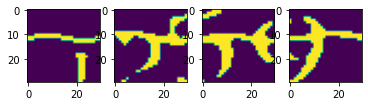

In [ ]:
# EXTRACT DIGITS FROM AN IMAGE
def digits_extraction(digits_center, preprocessd_image):
    digits = []
    for center in np.round(digits_center):
        start_row = int(center[0]-15)
        start_col = int(center[1]-15)
        if start_row<0: start_row=0
        if start_col<0: start_col=0
        digit = preprocessd_image[start_row:start_row+30, start_col:start_col+30]
        digits.append(digit)
    return digits


extracted_digits = digits_extraction(digits_center, preprocessed_image)

for i, digit in enumerate(extracted_digits, 1):
    plt.subplot(1,4, i)
    plt.imshow(digit)

# GATHER ALL OF FUNCTION TOGETHER

In [ ]:
images, dataset_path = load_images()
# image = 'captcha137.jpg'
for image in images:
    preprocessed_image = preprocessing(image, dataset_path)[0]
    if type(preprocessed_image) == np.ndarray:
        if np.max(np.histogram(preprocessed_image)[0]) < 6300:
            whitePX_cord = get_whitePX_cord(preprocessed_image)
            digits_center = get_digit_center_cord(whitePX_cord)
            # display_results(digits_center)
            extracted_digits = digits_extraction(digits_center, preprocessed_image)
            # plt.show()
            for i, digit in enumerate(extracted_digits, 1):
                plt.subplot(1,4, i)
                # plt.imshow(digit)
                # plt.show()
                if digit.size == 900:
                  plt.imsave(f'./digits-dataset2/{image[:-4]}-{i}.jpg', digit)

# Convoloutional model

## Loading data

In [ ]:
import pandas as pd

# LOAD LABELS DATA
with open('labels.txt') as f:
    labels = f.readlines()
    labels = [x.rstrip('\n') for x in labels]

labels_dict = {}
for elem in labels:
  elem = elem.split()
  if elem[0] not in labels_dict:
    labels_dict.update({elem[0]: int(elem[1])})


# LOAD DIGITS
X = []
root_path = os.path.join(os.getcwd(), 'digits-dataset2')
images_name = os.listdir(root_path)
images_path = [os.path.join(os.getcwd(), 'digits-dataset2', img) for img in images_name]

df = pd.DataFrame(columns=['name','digit','image'])
# df['name'] = list(labels_dict.keys())
# df['digit'] = list(labels_dict.values())

digits = []
names = []
for name in images_name:
  if name[:-4] in labels_dict:
    digits.append(labels_dict[name[:-4]])
    names.append(name[:-4])
    index = images_name.index(name)
    path = images_path[index]

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if image.size == 900:
      X.append(image)

df['name'] = names
df['digit'] = digits
df['image'] = X
X = np.array(X)

In [ ]:
a = []
for i in range(500):
  if i%2 == 0:
    a.append([i,1])
  else:
    a.append([i,0])

a = np.array(a)

x = a[:,0].reshape((len(a),1))
y = a[:,1]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model = DecisionTreeClassifier()
# model.fit(x, y)
model.fit(xtrain2, ytrain2)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
test = np.array([22,23,3,1,0,2,4,100])
test = np.reshape(test, (len(test),1))
model.predict(test)

array([1, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
ypred = model.predict(xtest2)
print(ytest2)
print(ypred)

print(classification_report(ytest2, ypred))

[0 8 0 4 6 9 2 4 1 9]
[2 2 2 2 2 2 2 2 2 2]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.10      1.00      0.18         1
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2

    accuracy                           0.10        10
   macro avg       0.01      0.14      0.03        10
weighted avg       0.01      0.10      0.02        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


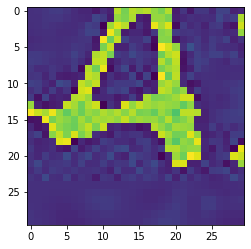

In [ ]:
plt.imshow(X[-10])

# Multi Class Classification

In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras import models
from keras import layers
import keras


(xtrain_28, ytrain_28), (xtest_28, ytest_28) = mnist.load_data()

# plt.imshow(xtrain[0], cmap=plt.cm.binary)

xtrain = np.reshape(xtrain_28, (xtrain_28.shape[0], 28*28))
xtrain = xtrain.astype('float32') / 255

xtest = np.reshape(xtest_28, (xtest_28.shape[0], 28*28))
xtest = xtest.astype('float32') / 255


In [ ]:
input_layer = keras.Input(shape=(28*28,))
x = layers.Dense(512, activation='relu', input_shape=(28 * 28,))(input_layer)
x = layers.Dense(256, activation='relu')(x)
out = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs=input_layer, outputs=out)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_130 (Dense)           (None, 512)               401920    
                                                                 
 dense_131 (Dense)           (None, 256)               131328    
                                                                 
 dense_132 (Dense)           (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
                xtrain,
                ytrain_28,
                # xtrain2,
                # ytrain2,
                verbose=1,
                epochs=3,
                # epochs=15,
                batch_size=128,
                # batch_size=2,
                validation_split=0.1,
            )

Epoch 1/3
422/422 [==============================] - 10s 22ms/step - loss: 0.2422 - accuracy: 0.9254 - val_loss: 0.1072 - val_accuracy: 0.9652
Epoch 2/3
422/422 [==============================] - 8s 18ms/step - loss: 0.0875 - accuracy: 0.9729 - val_loss: 0.0750 - val_accuracy: 0.9787
Epoch 3/3
422/422 [==============================] - 8s 19ms/step - loss: 0.0575 - accuracy: 0.9821 - val_loss: 0.0856 - val_accuracy: 0.9733


In [ ]:
# transfer learning
from tensorflow import keras
# model.layers[1].trainable = False
# model.layers[2].trainable = False


input_layer2 = keras.Input(shape=(28*28,))
transfered_layer = (model.layers[1])(input_layer2)
transfered_layer = (model.layers[2])(transfered_layer)
added_layer = layers.Dense(128, activation='relu')(transfered_layer)
added_layer = layers.Dense(10, activation='relu')(added_layer)
out2 = layers.Dense(10, activation='relu')(added_layer)
new_model = keras.Model(inputs=input_layer2, outputs=out2)

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
new_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='accuracy',)

new_model.layers[1].trainable = False
new_model.layers[2].trainable = False

new_model.summary()

Model: "model_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_130 (Dense)           (None, 512)               401920    
                                                                 
 dense_131 (Dense)           (None, 256)               131328    
                                                                 
 dense_184 (Dense)           (None, 128)               32896     
                                                                 
 dense_185 (Dense)           (None, 10)                1290      
                                                                 
 dense_186 (Dense)           (None, 10)                110       
                                                                 
Total params: 567,544
Trainable params: 34,296
Non-trainab

In [ ]:
# new_X = X[:,1:-1,1:-1]
new_X = X

xtrain2 = np.reshape(new_X, (new_X.shape[0], 30*30))

# train
xtrain2 = xtrain2[:-10]
xtrain2 = xtrain2.astype('float')/255
ytrain2 = df.digit.values[:-10]
#test
xtest2 = xtrain2[-10:]
xtest2 = xtest2.astype('float')/255
ytest2 = df.digit.values[-10:]

xtrain2.shape, xtest2.shape

((500, 900), (10, 900))

In [ ]:
history = new_model.fit(
                    xtrain2,
                    ytrain2,
                    verbose=1,
                    epochs=20,
                    batch_size=2,
                    # validation_split=0.1,
                )

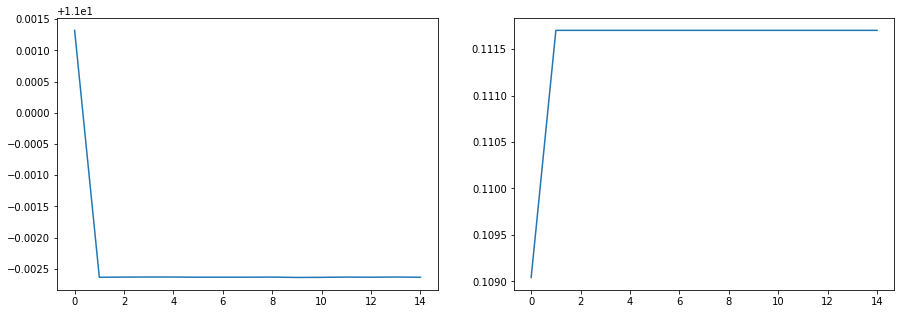

In [ ]:
train_items = ['loss','val_loss']
val_items = ['accuracy','val_accuracy']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history[train_items[0]])
# plt.plot(history.history[train_items[1]])

plt.subplot(1,2,2)
plt.plot(history.history[val_items[0]])
plt.plot(history.history[val_items[1]])

In [ ]:
# TEST 'MNIST' TRAINED MODEL USING MNIST TEST DATA
ypred = model.predict(xtest[0:1])

ytest_28[0], np.argmax(ypred)

(7, 7)

In [ ]:
# TEST 'MNIST' TRAINED MODEL USING EXTRACTED DIGITS
from sklearn.metrics import classification_report

ypred = new_model.predict(xtest2)

# ypred = model.predict(xtest)


# num_img = 10

# test_digit = df.image[0:num_img]
# test_digit = np.array([x[1:-1,1:-1] for x in test_digit])

# test_digit = np.reshape(test_digit, (test_digit.shape[0], 784))
# ypred = model.predict(test_digit)

ypred = [np.argmax(x) for x in ypred]
# print('core', [x for x in ytest2])
# print('pred', ypred)

# print(classification_report(ytest_28, ypred))
print(classification_report(ytest2, ypred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.10      1.00      0.18         1

    accuracy                           0.10        10
   macro avg       0.02      0.17      0.03        10
weighted avg       0.01      0.10      0.02        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


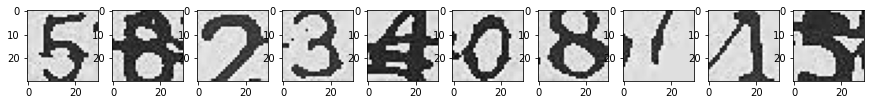

In [ ]:
plt.figure(figsize=(15,5))
for i in range(1,num_img+1):
  plt.subplot(1,num_img,i)
  plt.imshow(df.image[i-1], cmap=plt.cm.binary)

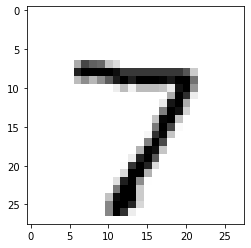

In [ ]:
plt.imshow(xtest_28[0], cmap=plt.cm.binary)

In [ ]:
ypred = model.predict(xtest)

a = [np.argmax(x) for x in ypred]
for i,j in zip(a, ytest):
  print(i, j)

3 1
9 9
4 6
7 8
4 3
5 0
6 7
3 6
4 9
2 7


# Change filename to their content digits

In [ ]:
import cv2
from matplotlib import pyplot as plt
import pandas as pd

with open('./labels2.txt') as f:
    labels = f.readlines()
    labels = [x.rstrip('\n') for x in labels]


df = pd.DataFrame({
    'digits':labels,
    'pre_name':None,
    'new_name':None
})

for d in labels:
    i = labels.index(d)
    df['pre_name'].loc[i] = f'captcha{i+1}.jpg'
    df['new_name'].loc[i] = i+1

df.drop_duplicates(subset='digits', inplace = True)
df.reset_index(inplace=True, drop=True)

df[df['new_name']==40]


,digits,pre_name,new_name
39,7324,captcha40.jpg,40


In [ ]:
root_path = os.path.join(os.getcwd(), 'dataset - copy')
new_root_path = os.path.join(os.getcwd(), 'dataset - copy', 'test')

for x in df.index:
    pre_name = os.path.join(root_path, df.iloc[x].pre_name)
    new_name = os.path.join(new_root_path, df.iloc[x].digits+'.jpg')
    # print(pre_name, new_name)
    # print(x)
    os.rename(pre_name, new_name)
    # if x==10:
    # break

# Multi Label Classification

In [5]:
symbols = "0123456789"
num_digits = 4

In [88]:
# Load Images and preprocess them
# def preprocess(img):
#   img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#   return img

# images = []
# for name in os.listdir('/content/dataset'):
#   img = cv2.imread(os.path.join('/content/dataset', name))
#   if img is not None:
#     img = preprocess(img)
#     img = np.reshape(img, (img.shape[0], img.shape[1], 1 ))
#     # b = np.array([[255]*152]*10)
#     # img = np.concatenate((img, b))
#     images.append(img)


# x = np.array(images)
# x = X.astype('float')/255.0
# # X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
# x.shape

#################### 5 digits kaggle captcha ########################
# https://www.kaggle.com/fournierp/captcha-version-2-images

# names = []
# for name in os.listdir('/content/samples'):
#   if name != 'samples':
#     names.append(name[:-4])

# numbers = ['0','1','2','3','4','5','6','7','8','9']
# char = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q',
#         'r','s','t','u','v','w','x','y','z']
# total_char = numbers+char

# multi_hot_labels = []
# for name in names:
#   tmp = np.zeros(len(total_char), dtype='int32')
#   if name != 'samples':
#     for char in name:
#       i = total_char.index(char)
#       tmp[i] = 1
#     multi_hot_labels.append(tmp)

# Y = multi_hot_labels
# Y = np.array(Y)


# def convert_binary_labels_to_labels(bin_labels):
#   digits = []
#   for i, elem in enumerate(bin_labels):
#     if elem == 1:
#       digits.append(str(i))
#   return ''.join(digits)

# def convert_labels_to_binary_labels(labels):
#   bin_labels = np.zeros((labels.shape[0], 35), dtype='int32')
#   for i, elem in enumerate(labels):
#     for digit in elem:
#       bin_labels[i][int(digit)] = 1
#   return bin_labels


# multi_hot_labels[0], names[0], Y.shape

(2999, 4, 10)

## Load and prepair data

In [142]:
# Load labels and preprocss them
with open('labels2.txt') as f:
    labels = f.readlines()
    labels = [x.rstrip('\n') for x in labels]
    labels = np.array(labels)


# Make X,y from image and labels files
def preprocess_data():
    n_samples = len(os.listdir('/content/dataset'))
    X = np.zeros((n_samples, 42, 152, 1)) #1070*50*200
    y = np.zeros((4, n_samples, len(symbols))) #5*1070*36

    for i, pic in enumerate(os.listdir('/content/dataset')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('/content/dataset', pic), cv2.IMREAD_GRAYSCALE)
        pic_id = int(pic[:-4].replace('captcha',''))-1
        pic_target = labels[pic_id]
        if len(pic_target) < 5:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (42, 152, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((4, len(symbols)))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, Y = preprocess_data()

In [143]:
# Split and prepair data for model fitting

xtrain, ytrain = X[:2900], Y[:, :2900]
xtest, ytest = X[2900:], Y[:, 2900:]

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((2900, 42, 152, 1), (4, 2900, 10), (99, 42, 152, 1), (4, 99, 10))

## Define model

In [117]:
# create VGG16 for transfer learning

base_model = keras.applications.VGG16(
                weights='imagenet',  # Load weights pre-trained on ImageNet.
                input_shape=(50, 200, 3), # VGG16 expects min 32 x 32
                include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False


# base_model.summary()

In [118]:
# Create the classification model

def create_model():
  number_of_classes = 10

  inputs = keras.Input(shape=(50, 200, 3), name='classifier_model_inputs')
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(512, activation='relu',
                         kernel_regularizer=keras.regularizers.l1(0.01)
                         )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(256, activation='relu',
                         kernel_regularizer=keras.regularizers.l1(0.01)
                         )(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dense(128, activation='relu',
                         kernel_regularizer=keras.regularizers.l1(0.01)
                         )(x)
  x = keras.layers.BatchNormalization()(x)

  initializer = tf.keras.initializers.GlorotUniform(seed=42)

  outputs = keras.layers.Dense(number_of_classes,
                              kernel_initializer=initializer,
                              kernel_regularizer=keras.regularizers.l1(0.01),
                              activation='sigmoid')(x)


  model = keras.Model(inputs, outputs)

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.01),
      loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
      # metrics=['accuracy']
      metrics=[keras.metrics.BinaryAccuracy()]
      )
  model.summary()
  return model

In [8]:
from keras import layers
from tensorflow import keras

# input_layer = keras.Input(shape=(200*50,))
# x = layers.Dense(4096, activation='relu')(input_layer)
# x = layers.Dense(2048, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dense(128, activation='relu')(x)
# out = layers.Dense(36, activation='softmax')(x)
# model = keras.Model(inputs=input_layer, outputs=out)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')
# model.summary()


def create_model():
  img_shape=(42,152,1)
  num_symbols=len(symbols)
  img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
  conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
  mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
  conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
  mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
  conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
  bn = layers.BatchNormalization()(conv3)
  mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
  # Get flattened vector and make 5 branches from it. Each branch will predict one letter
  # dns = layers.Dense(1024, activation='relu')(mp3)
  flat = layers.Flatten()(mp3)

  outs = []
  for _ in range(4):
    dens1 = layers.Dense(64, activation='relu')(flat)
    drop = layers.Dropout(0.5)(dens1)
    res = layers.Dense(num_symbols, activation='sigmoid')(drop)

    outs.append(res)
    
  # Compile model and return it
  model = keras.Model(img, outs)
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
  return model

# Model fitting

In [9]:
model = create_model()

hist = model.fit(xtrain, [ytrain[0], ytrain[1], ytrain[2], ytrain[3]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)


# history = model.fit(
#                 xtrain,
#                 ytrain,
#                 epochs=100,
#                 batch_size=128,
#                 validation_split=0.2,
#                 # callbacks = [plot_losses]
#             )

Epoch 1/30
73/73 [==============================] - 17s 33ms/step - loss: 9.3122 - dense_1_loss: 2.2911 - dense_3_loss: 2.3338 - dense_5_loss: 2.3453 - dense_7_loss: 2.3420 - dense_1_accuracy: 0.1341 - dense_3_accuracy: 0.0966 - dense_5_accuracy: 0.1091 - dense_7_accuracy: 0.1004 - val_loss: 9.1797 - val_dense_1_loss: 2.2758 - val_dense_3_loss: 2.3023 - val_dense_5_loss: 2.3018 - val_dense_7_loss: 2.2998 - val_dense_1_accuracy: 0.1103 - val_dense_3_accuracy: 0.0948 - val_dense_5_accuracy: 0.1000 - val_dense_7_accuracy: 0.1310
Epoch 2/30
73/73 [==============================] - 1s 20ms/step - loss: 9.0085 - dense_1_loss: 2.1656 - dense_3_loss: 2.2868 - dense_5_loss: 2.2785 - dense_7_loss: 2.2776 - dense_1_accuracy: 0.1767 - dense_3_accuracy: 0.1177 - dense_5_accuracy: 0.1427 - dense_7_accuracy: 0.1366 - val_loss: 9.1311 - val_dense_1_loss: 2.2487 - val_dense_3_loss: 2.2963 - val_dense_5_loss: 2.2961 - val_dense_7_loss: 2.2900 - val_dense_1_accuracy: 0.1293 - val_dense_3_accuracy: 0.1155

## Save/Load Model

In [12]:
from keras.models import load_model

saveFlag = False

if saveFlag == True:
  model.save('Captcha_Recog.h5')
  print("Saved model to disk")
else:
  # load model
  model = load_model('/content/drive/MyDrive/prj/captcha_recognition/Captcha_Recog.h5')

# !cp /content/Captcha_Recog.h5 /content/drive/MyDrive/prj/captcha_recognition

## Model prediction

### ML model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(xtrain, ytrain)

In [ ]:
i=0
ypred = clf.predict(xtest)

print('corr', convert_binary_labels_to_labels(ytest[i]))
print('pred', convert_binary_labels_to_labels(ypred[i]))

print(classification_report(ytest, ypred))

corr 1469
pred 0246
              precision    recall  f1-score   support

           0       0.41      0.41      0.41        39
           1       0.43      0.39      0.41        57
           2       0.49      0.38      0.43        61
           3       0.34      0.38      0.36        50
           4       0.27      0.36      0.31        45
           5       0.31      0.27      0.29        56
           6       0.23      0.27      0.25        49
           7       0.35      0.41      0.38        51
           8       0.39      0.44      0.41        50
           9       0.33      0.31      0.32        58

   micro avg       0.35      0.36      0.35       516
   macro avg       0.35      0.36      0.36       516
weighted avg       0.36      0.36      0.36       516
 samples avg       0.35      0.36      0.35       516



### DL model

In [14]:
score = model.evaluate(xtest, [ytest[0], ytest[1], ytest[2], ytest[3]])
print('Test Loss:', score[:5])
print('Test accu:', score[5:])

4/4 [==============================] - 0s 88ms/step - loss: 0.6987 - dense_1_loss: 0.1079 - dense_3_loss: 0.2450 - dense_5_loss: 0.1410 - dense_7_loss: 0.2048 - dense_1_accuracy: 0.9798 - dense_3_accuracy: 0.9596 - dense_5_accuracy: 0.9293 - dense_7_accuracy: 0.9596
Test Loss: [0.6986818909645081, 0.1078793853521347, 0.24501049518585205, 0.14103299379348755, 0.20475901663303375]
Test accu: [0.9797979593276978, 0.9595959782600403, 0.9292929172515869, 0.9595959782600403]


In [15]:
def predict(filePath):
  img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
  if img is not None:
      img = img.astype('float') / 255.0
  else:
      print("Not detected");
  res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
  ans = np.reshape(res, (num_digits, len(symbols)))
  l_ind = []
  probs = []
  for a in ans:
      l_ind.append(np.argmax(a))
      #probs.append(np.max(a))

  capt = ''
  for l in l_ind:
      capt += symbols[l]
  return capt#, sum(probs) / 5

True captcha: [6 5 1 6]


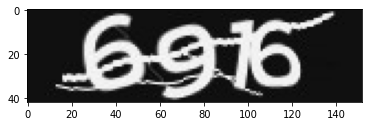

In [53]:
# Predict by xtrain, xtest

i = 1
plt.imshow(np.reshape(xtest[i], (42,152)), cmap=plt.cm.binary)
ypred = model.predict(xtest[i:i+1])
ypred = np.array(ypred)
ypred = np.reshape(ypred, (4,10))
ypred = np.argmax(ypred, axis=1)
# ypred  = [np.argmax(x) for x in ypred]
print(f'True captcha: {ypred}')

Predicted Captcha = 7496
Delay is 0.06490373611450195 sec


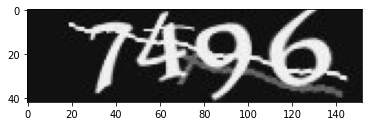

In [17]:
#Lets test an unknown captcha (by path)
#preview
%matplotlib inline 
import matplotlib.pyplot as plt

i=2500
test_img_path = f'/content/dataset/captcha{i}.jpg'

t = time.time()

img=cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

#Lets Predict By Model
print("Predicted Captcha =",predict(test_img_path))
print(f'Delay is {time.time()-t} sec')

In [173]:
from sklearn.metrics import classification_report

ypred = model.predict(xtest)
ypred = np.array(ypred)

a= ypred[0:1,:,:]
b= ypred[1:2,:,:]
c= ypred[2:3,:,:]
d= ypred[3:4,:,:]
ypred = np.concatenate((a,b,c,d), axis=1).reshape((396, 10))
# ypred = np.argmax(ypred, axis=0)

for i, elem in enumerate(ypred):
  tmp = [0]*10
  argmax = np.argmax(elem)
  tmp[argmax] = 1
  ypred[i] = tmp


a= ytest[0:1,:,:]
b= ytest[1:2,:,:]
c= ytest[2:3,:,:]
d= ytest[3:4,:,:]
ytrue = np.concatenate((a,b,c,d), axis=1).reshape((396, 10))
# ytrue = np.argmax(ytrue, axis=0)

for i, elem in enumerate(ytrue):
  tmp = [0]*10
  argmax = np.argmax(elem)
  tmp[argmax] = 1
  ytrue[i] = tmp

print(classification_report(ytrue, ypred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.92      0.96        48
           2       0.97      1.00      0.99        36
           3       0.95      0.86      0.90        44
           4       0.89      1.00      0.94        40
           5       0.89      0.94      0.92        35
           6       0.93      1.00      0.96        40
           7       0.96      0.96      0.96        46
           8       0.98      0.93      0.95        43
           9       0.97      0.93      0.95        40

   micro avg       0.95      0.95      0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396
 samples avg       0.95      0.95      0.95       396



In [ ]:
from sklearn.metrics import classification_report
i=0

def convert_logits_to_digits(logits):
  logits = heapq.nlargest(5, range(len(logits)), logits.__getitem__)
  logits = [str(x) for x in logits]
  logits = ''.join(logits)
  return logits

ypred = model.predict(xtest)

predicted_digits = []
predicted_bin_digits = []
for elem in ypred:
  digits = convert_logits_to_digits(elem)
  predicted_digits.append(digits)
  predicted_bin_digits.append(convert_labels_to_binary_labels(np.array([digits])))

predicted_bin_digits = np.array(predicted_bin_digits)
predicted_bin_digits = np.reshape(predicted_bin_digits, (ytest.shape[0], ytest.shape[1]))


# print('corr', ytest_digits[:10])
# print('pred', predicted_digits[:10])

print(classification_report(ytest, predicted_bin_digits))